<a href="https://colab.research.google.com/github/namirafr/Cassava-Leaves-Classification/blob/main/EfficientNetB3_(old)_Dataset_TA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"adityafah","key":"e90a3c4bc5afa6dcfbce166d48b513a2"}'}

In [3]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle competitions download -c cassava-disease

 98% 760M/777M [00:05<00:00, 154MB/s]
100% 777M/777M [00:05<00:00, 150MB/s]
  0% 0.00/83.8k [00:00<?, ?B/s]
100% 83.8k/83.8k [00:00<00:00, 53.4MB/s]
 97% 500M/515M [00:03<00:00, 152MB/s]
100% 515M/515M [00:03<00:00, 142MB/s]
100% 1.04G/1.04G [00:19<00:00, 27.1MB/s]
100% 1.04G/1.04G [00:19<00:00, 56.4MB/s]
  0% 0.00/645k [00:00<?, ?B/s]
100% 645k/645k [00:00<00:00, 90.8MB/s]


In [5]:
! mkdir train
! unzip train.zip -d train
! mkdir test
! unzip test.zip -d test

Streaming output truncated to the last 5000 lines.
  inflating: train/train/cbsd/train-cbsd-685.jpg  
  inflating: train/train/cbsd/train-cbsd-74.jpg  
  inflating: train/train/cbsd/train-cbsd-875.jpg  
  inflating: train/train/cbsd/train-cbsd-861.jpg  
  inflating: train/train/cbsd/train-cbsd-60.jpg  
  inflating: train/train/cbsd/train-cbsd-1165.jpg  
  inflating: train/train/cbsd/train-cbsd-134.jpg  
  inflating: train/train/cbsd/train-cbsd-652.jpg  
  inflating: train/train/cbsd/train-cbsd-646.jpg  
  inflating: train/train/cbsd/train-cbsd-120.jpg  
  inflating: train/train/cbsd/train-cbsd-1171.jpg  
  inflating: train/train/cbsd/train-cbsd-108.jpg  
  inflating: train/train/cbsd/train-cbsd-1159.jpg  
  inflating: train/train/cbsd/train-cbsd-1158.jpg  
  inflating: train/train/cbsd/train-cbsd-109.jpg  
  inflating: train/train/cbsd/train-cbsd-647.jpg  
  inflating: train/train/cbsd/train-cbsd-1170.jpg  
  inflating: train/train/cbsd/train-cbsd-121.jpg  
  inflating: train/train/cbs

In [6]:
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [7]:
import tensorflow as tf
import tensorflow_addons as tfa
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.efficientnet import EfficientNetB3

import matplotlib.pyplot as plt

In [8]:
base_dir = 'train/train'

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    shear_range = 0.2,
    rotation_range = 40,
    fill_mode = 'nearest',
    validation_split = 0.2
)

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size = (224, 224),
	  class_mode = 'categorical',
    batch_size = 16,
    subset = 'training'
)

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size = (224, 224),
	  class_mode = 'categorical',
    batch_size = 16,
    subset = 'validation'
)

Found 4527 images belonging to 5 classes.
Found 1129 images belonging to 5 classes.


In [9]:
labels = train_generator.class_indices
print(labels)

{'cbb': 0, 'cbsd': 1, 'cgm': 2, 'cmd': 3, 'healthy': 4}


In [10]:
base_model = EfficientNetB3(
    include_top=False,
    weights=None,
    input_shape=(224, 224, 3)
)

In [11]:
base_model.summary()

Model: "efficientnetb3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0

In [12]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=True)
x = layers.Flatten()(x)
outputs = layers.Dense(5, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb3 (Functional)  (None, 7, 7, 1536)       10783535  
                                                                 
 flatten (Flatten)           (None, 75264)             0         
                                                                 
 dense (Dense)               (None, 5)                 376325    
                                                                 
Total params: 11,159,860
Trainable params: 11,072,557
Non-trainable params: 87,303
_________________________________________________________________


In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['acc', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=5)])

In [15]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=25,
                    verbose=1
                    )

Epoch 1/25
283/283 [==============================] - 227s 701ms/step - loss: 2.7523 - acc: 0.4049 - precision: 0.4279 - recall: 0.2728 - f1_score: 0.2222 - val_loss: 1.5825 - val_acc: 0.4287 - val_precision: 0.3855 - val_recall: 0.1461 - val_f1_score: 0.2168
Epoch 2/25
283/283 [==============================] - 191s 676ms/step - loss: 1.6670 - acc: 0.4873 - precision: 0.5427 - recall: 0.2889 - f1_score: 0.2391 - val_loss: 1.8306 - val_acc: 0.4960 - val_precision: 0.5719 - val_recall: 0.3384 - val_f1_score: 0.2407
Epoch 3/25
283/283 [==============================] - 193s 680ms/step - loss: 1.5415 - acc: 0.5017 - precision: 0.5711 - recall: 0.2874 - f1_score: 0.2259 - val_loss: 1.5598 - val_acc: 0.4889 - val_precision: 0.5588 - val_recall: 0.3578 - val_f1_score: 0.2119
Epoch 4/25
283/283 [==============================] - 192s 679ms/step - loss: 1.4321 - acc: 0.5096 - precision: 0.5785 - recall: 0.3141 - f1_score: 0.2337 - val_loss: 1.3420 - val_acc: 0.5190 - val_precision: 0.6092 - va

In [16]:
import os
length = 0
lengths = {}
train_dir = 'train/train'
for folder in os.listdir(train_dir):
  lengths[folder] = len(os.listdir(os.path.join(train_dir, folder)))
print(lengths)

{'cgm': 773, 'healthy': 316, 'cbsd': 1443, 'cmd': 2658, 'cbb': 466}


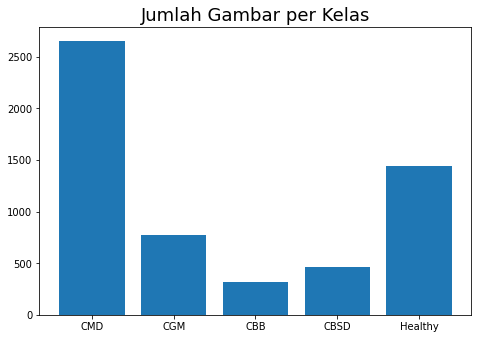

In [17]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['CMD', 'CGM', 'CBB', 'CBSD', 'Healthy']
y = [lengths['cmd'], lengths['cgm'], lengths['healthy'], lengths['cbb'], lengths['cbsd']]
ax.set_title('Jumlah Gambar per Kelas', fontsize=18)
ax.bar(x, y)
plt.show()

In [18]:
from PIL import Image, ImageFile

dir = 'train/train/'

resolutions = []
for folder in os.listdir(train_dir):
  path = os.path.join(dir, folder)
  for file in os.listdir(path):
    with Image.open(os.path.join(path, file)) as img:
      width, height = img.size
    resolutions.append([width, height])
print('Minimum resolution: {}'.format(min(resolutions)))
print('Maximum resolution: {}'.format(max(resolutions)))

Minimum resolution: [424, 500]
Maximum resolution: [1622, 500]
